In [79]:
import random
import statistics as st
import math

# Optimal Player Prediction
The optimal player will only make decisions that have a positive expected value
In the game of pig, for one single roll, we have 6 different possibilities
5 out of those 6 possibilities have a definite outcome, and these are in vals
Expected Value = sum of outcomes times their probability
               = score/6 + 1/6 + 2/6 + 3/6 + 4/6 + 5/6 + 6/6
It becomes clear that this expression is 0 when sore is equal to sum(vals) = 20
So the optimal player should roll again when his/her score is below 20
                  and should quit when the score is above 20
The behavior at 20 shouldn't matter

In [80]:
vals = [i for i in range(2,7)]
print(vals)
print(sum(vals)/len(vals))
print(sum(vals))

[2, 3, 4, 5, 6]
4.0
20


#Building the Game Strucutures
First we need a Die() function which rolls the dice
Next, we have classes for the turn, the game, and the player
The player classes are extended to represent different strategies
The default strategy only rolls once
The two next strategies take the optimal action, with the first one always rolling on 20
and the 2nd one always quitting on 20

In [81]:
def Die(): return random.randint(1,6)

In [82]:
[Die() for i in range(10)] # looks like some good random dice rolls

[3, 2, 3, 5, 3, 5, 2, 4, 6, 4]

In [83]:
class Game:
    def __init__(self, player1, player2=None):
        self.p1 = player1
        self.p2 = player2
        if player2 is not None:
            self.score_limit = 100
            self.p = 1
        else:
            self.turn_limit = 7
    
    def restart(self):
        self.turns = 0
        self.p1.score = 0
        if self.p2 is not None:
            self.p2.score = 0
            
    def start(self):
        '''This plays a full game'''
        self.restart()
        player = self.cp()
        while self.not_finished():
            turn = Turn(player)
            turn.go()
            player.score += turn.score
            self.turns += 1
            if self.p2 is not None:
                self.sp()
                player = self.cp()
        if self.p2 is None:
            return player.score
        else:
            return (self.p1.score, self.p2.score)
    
    def not_finished(self):
        if self.p2 is not None:
            return max(self.p1.score, self.p2.score) < self.score_limit
        else:
            return self.turns < self.turn_limit
        
    def cp(self):
        '''Returns current player'''
        if self.p2 is None:
            return self.p1
        elif self.p == 1:
            return self.p1
        else:
            return self.p2
    
    def sp(self):
        '''Switches current player'''
        if self.p == 1:
            self.p = 2
        else:
            self.p = 1
                
class Turn:
    def __init__(self, player):
        self.player = player
        self.score = 0
    
    def go(self):
        '''This carries out a full turn'''
        self.roll = 0
        self.score = 0
        while True:
            self.roll += 1
            do_roll = self.player.will_roll(self.roll, self.score)
            if not do_roll:
                break
            number = Die()
            if number == 1:
                self.score = 0
                break
            self.score += number
        #return score
    
class Player:
    def __init__(self, name):
        self.name = name
        self.score = 0
        self.hist = []
    
    def __str__(self):
        return self.name
        
    def will_roll(self, roll, score, other_players_score=0):
        return roll <= 1
        
    def run_hist(self, n):
        self.hist = [0] * n
        game = Game(self)
        for i in range(n):
            self.hist[i] = game.start()
            
    def hist_summary(self):
        ret_st = ""
        n = len(self.hist)
        the_std = st.stdev(self.hist)
        ret_st += self.name.ljust(10)+" gets a mean of: "+str(round(sum(self.hist)/n,3))
        ret_st += " std: "+str(round(the_std,2))
        ret_st += " mean error: "+ str(round(the_std/math.sqrt(n),4))
        return ret_st

class ScoreBasedPlayer(Player):
    def will_roll(self, roll, score, other_players_score=0):
        return score <= 20

class SBP_conservative(Player):
    def will_roll(self, roll, score, other_players_score=0):
        return score < 20
    
class RandomPlayer(Player): # random chance of quitting
    def will_roll(self, roll, score, other_players_score=0):
        return Die() > 2
    
class TurnBasedPlayer(Player): # quits after a certain turn
    def will_roll(self, roll, score, other_players_score=0):
        return roll <= 3
            

#Running Statistics
Tests are run for the different strategies. We use the history logging methods of the user class and then return some statics and draw conclusions from them.

In [84]:
all_players = [] # Create sample players of all types
all_players.append( Player("Johnny") )
all_players.append( ScoreBasedPlayer("Milton") ) # named after economists
all_players.append( SBP_conservative("Adam Smith") )
all_players.append( TurnBasedPlayer("Crazy Ivan"))
all_players.append( RandomPlayer("Karl M."))

In [85]:
Nval = 10000

In [86]:
for player in all_players:
    print(str(player)+" - running history")
    player.run_hist(Nval)

Johnny - running history
Milton - running history
Adam Smith - running history
Crazy Ivan - running history
Karl M. - running history


In [87]:
for player in all_players:
    print(player.hist_summary())

Johnny     gets a mean of: 23.334 std: 5.23 mean error: 0.0523
Milton     gets a mean of: 56.726 std: 28.55 mean error: 0.2855
Adam Smith gets a mean of: 57.154 std: 28.0 mean error: 0.28
Crazy Ivan gets a mean of: 48.579 std: 16.33 mean error: 0.1633
Karl M.    gets a mean of: 26.51 std: 17.16 mean error: 0.1716


Note that Milton and Adam's scores are so close that the error in the mean is larger than the difference between them. The error in the mean is computed from the standard deviation divided by the square root of the number of trials, and it represents the statistical measurement error on the value we report of the average score. From these numbers, we conclude that our experiment was not capable of measuring a difference in performance between Milton and Adam. That supports the original hypothesis that they would perform equally well.

#Distribution Plots
These are mostly histogram graphs that show the distribution of scores.
This is based on a 7-round game played by a single player.

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

Number of bins: 38


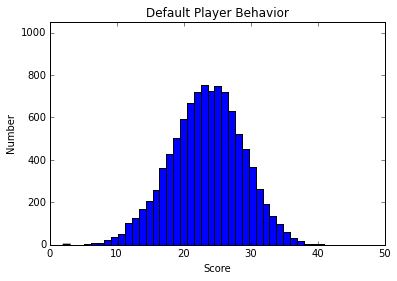

In [89]:
scale = max(all_players[0].hist)-min(all_players[0].hist)-1 # number of integers that the range spans, 
                                                            # -1 to be pythonic
print("Number of bins: "+str(scale))
max_y = int(Nval/scale*4) # set the window by the average histogram value times a fill factor

plt.title("Default Player Behavior")
plt.xlabel("Score")
plt.ylabel("Number")
plt.axis((0,50,0,max_y))
plt.hist(all_players[0].hist, bins=scale)

plt.show()

This shows the distribution of scores for the default player
It is mostly normally distributed, but the value of 0 for rolls of 1 leaves a bit of a longer tail on the left

161
153


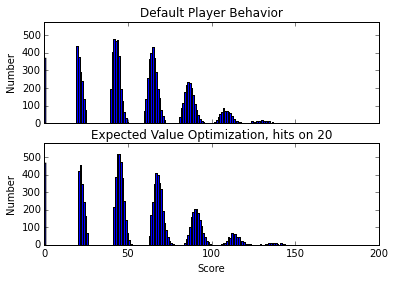

In [90]:
scale1 = max(all_players[1].hist)-min(all_players[1].hist)-1 # same calculation for number of bins
print(scale1)
scale2 = max(all_players[2].hist)-min(all_players[2].hist)-1
print(scale2)
max_y = int(Nval/scale*2.2)

ax2 = plt.subplot(212)
plt.title("Expected Value Optimization, hits on 20")
plt.xlabel("Score")
plt.ylabel("Number")
plt.hist(all_players[1].hist, bins=scale1)
plt.axis((1,200,0,max_y))
#plt.yscale("log")

ax1 = plt.subplot(211, sharex=ax2)
plt.title("Default Player Behavior")
plt.ylabel("Number")
plt.hist(all_players[2].hist, bins=scale2)
plt.axis((0,200,0,max_y))
plt.setp( ax1.get_xticklabels(), visible=False)

plt.show()

Now, this shows some more interesting behavior. Compared to the default player, these players tend to go deep into the betting round and quite often lose their entire pot. This behavior causes the distribution to be extremely multi-nodal. The peaks represent different numbers of "1" rolled. The highest score peak represents no loses of the pot, while the first and 2nd nodes represent 6 and 5 rolls of "1" respectively.

Number of bins: 97
Crazy Ivan


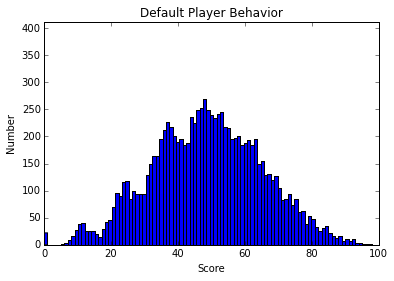

In [91]:
i = 3
scale = max(all_players[i].hist)-min(all_players[i].hist)-1 # number of integers that the range spans, 
                                                            # -1 to be pythonic
print("Number of bins: "+str(scale))
print(all_players[i])
max_y = int(Nval/scale*4) # set the window by the average histogram value times a fill factor

plt.title("Default Player Behavior")
plt.xlabel("Score")
plt.ylabel("Number")
plt.axis((0,100,0,max_y))
plt.hist(all_players[i].hist, bins=scale)

plt.show()

A random decision is made whether to keep going or now here. This makes the distribution surprisingly symmetrical. This might be due to the fact that it's hard to make its outcome zero, since sometimes it even quits after the first turn. Also, the user fails to consolidate very large gains by continuing to bet at times when he/she shouldn't. These factors somewhat help to explain the shape of the distribution.

Number of bins: 150
Karl M.


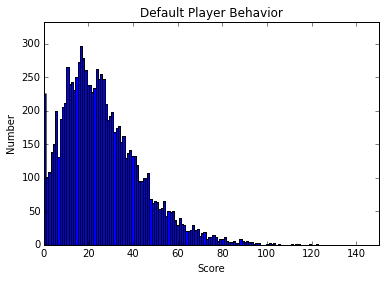

In [92]:
i = 4
scale = max(all_players[i].hist)-min(all_players[i].hist)-1 # number of integers that the range spans, 
                                                            # -1 to be pythonic
print("Number of bins: "+str(scale))
print(all_players[i])
max_y = int(Nval/scale*5) # set the window by the average histogram value times a fill factor

plt.title("Default Player Behavior")
plt.xlabel("Score")
plt.ylabel("Number")
plt.axis((0,150,0,max_y))
plt.hist(all_players[i].hist, bins=scale)

plt.show()

In this strategy, a set number of rolls are made every time (unless 1s are rolled before then). Since it doesn't depend on the score of the player, the strategy is named after the founder of communism. This distribution is more concentrated around the lower total scores with only a slight pick up at 0 itself. This looks somewhat Poisson, which might be the simple case of just adding dice rolls.

#Multi-player Games
Statics for 2-player games

In [93]:
milton=all_players[1]
adam = all_players[2]

In [94]:
game = Game(milton, adam)

In [95]:
print([game.start() for i in range(10)])

[(116, 90), (47, 109), (22, 107), (110, 42), (88, 106), (92, 108), (118, 84), (86, 110), (21, 109), (118, 20)]


Outcomes look sufficiently random, and also consistent with the rules

In [112]:
milton2 = ScoreBasedPlayer("Milton2")
game = Game(milton, milton2)

In [118]:
Nval = 10000
wins = 0
for i in range(Nval):
    p1s, p2s = game.start()
    if p1s > p2s:
        wins += 1
print("First player wins "+str(wins*100/(Nval))+" % of the time")

First player wins 49.15 % of the time


This shows the first-player advantage, but it confusingly says that the first player is at a disadvantage

In [96]:
Nval = 1000

In [99]:
n = len(all_players)
win_mat = [[0 for i in range(n)] for i in range(n)]
for i in range(n):
    for j in range(n):
        game = Game(all_players[i], all_players[j])
        if i != j:
            for k in range(Nval):
                p1s, p2s = game.start()
                if p1s > p2s:
                    win_mat[i][j] += 1
print(win_mat)

[[0, 9, 15, 3, 374], [986, 0, 461, 602, 916], [999, 522, 0, 641, 945], [997, 412, 350, 0, 910], [603, 78, 55, 81, 0]]


In [102]:
st = "          "
for j in range(n):
    st += all_players[j].name.rjust(15)
print(st)
for i in range(n):
    st = all_players[i].name.rjust(10)
    for j in range(n):
        st += str(round(win_mat[i][j]/Nval,4)).rjust(15)
    print(st)

                   Johnny         Milton     Adam Smith     Crazy Ivan        Karl M.
    Johnny            0.0          0.009          0.015          0.003          0.374
    Milton          0.986            0.0          0.461          0.602          0.916
Adam Smith          0.999          0.522            0.0          0.641          0.945
Crazy Ivan          0.997          0.412           0.35            0.0           0.91
   Karl M.          0.603          0.078          0.055          0.081            0.0
